In [1]:
import os
import uproot as ur
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
paths = []

for (path, dirnames, filenames) in os.walk('/mnt/scratch3/dmisra/zdcdata_current/'):
    paths.extend(os.path.join(path, name) for name in filenames)

In [3]:
samples = {}

for path in paths:
    with ur.open(path) as file:
       tree = file["events"]
       samples[os.path.basename(f'{path}')] = tree.arrays()

In [4]:
def bitExtract(n, k, p):  
    return (((1 << k) - 1)  &  (n >> (p-1)))

Energy Deposition per Layer

In [5]:
def layer_edep(data, count):
    edep = pd.DataFrame()
    energy_labels = []
    branches = ['ZDC_SiliconPix_Hits', 'ZDC_WSi_Hits', 'ZDC_PbSi_Hits', 'ZDCHcalHits']
    temp = pd.DataFrame()
    
    for i in range(count):
        index = str(i)
        label = np.sqrt(data["MCParticles.momentum.x"][0,0]**2 + data["MCParticles.momentum.y"][0,0]**2 + data["MCParticles.momentum.z"][0,0]**2)
        energy_labels.append(label)
        component_edep = pd.DataFrame()

        #Energy deposition in each crystal
        energies = np.array(data["ZDCEcalHits.energy"][i])
        cellID = np.array(data["ZDCEcalHits.cellID"][i])
        crystalID = bitExtract(cellID, 12, 11)
        df = pd.DataFrame({f'{index}': energies, 'crystalID': crystalID})
        crystals = df.groupby("crystalID").sum()
        component_edep = pd.concat([component_edep,crystals[f'{index}']],axis=1)
          
        #Energy deposition in imaging & segmented calorimetery
        for branch in branches:
            energies = np.array(data[f"{branch}.energy"][i])
            cellID = np.array(data[f"{branch}.cellID"][i])
            layerID = bitExtract(cellID, 6, 9)
            df = pd.DataFrame({f'{index}': energies, 'layerID': layerID})
            layers = df.groupby("layerID").sum()
            component_edep = pd.concat([component_edep,layers[f'{index}']],axis=1)

        edep = pd.concat([edep, component_edep],axis=1)

        #Format data as input for deep neural network
        edep_melted = edep[f'{i}'].melt(ignore_index=True).reset_index(drop=True)['value']
        temp = pd.concat([temp,edep_melted],axis=1)
        formatted_data = temp.T.reset_index(drop=True)
        
    return formatted_data, energy_labels

Data

In [65]:
data_features = pd.concat([layer_edep(samples[key], 10000)[0] for key in samples]).replace(np.NaN,0)
data_features.to_csv('/home/dmisra/eic/zdc_data/dnn_features.csv', index=False)

In [66]:
data_labels = np.array([layer_edep(samples[key], 10000)[1] for key in samples]).flatten()
np.savetxt('/home/dmisra/eic/zdc_data/dnn_labels.csv', data_labels)

In [67]:
data_features_10GeV = layer_edep(samples['zdc_neutron_10GeV_10e4.edm4hep.root'], 10000)[0].replace(np.NaN,0)
data_features_10GeV.to_csv('/home/dmisra/eic/zdc_data/dnn_features_10GeV.csv', index=False)

data_features_50GeV = layer_edep(samples['zdc_neutron_50GeV_10e4.edm4hep.root'], 10000)[0].replace(np.NaN,0)
data_features_50GeV.to_csv('/home/dmisra/eic/zdc_data/dnn_features_50GeV.csv', index=False)

data_features_100GeV = layer_edep(samples['zdc_neutron_100GeV_10e4.edm4hep.root'], 10000)[0].replace(np.NaN,0)
data_features_100GeV.to_csv('/home/dmisra/eic/zdc_data/dnn_features_100GeV.csv', index=False)

data_features_200GeV = layer_edep(samples['zdc_neutron_200GeV_10e4.edm4hep.root'], 10000)[0].replace(np.NaN,0)
data_features_200GeV.to_csv('/home/dmisra/eic/zdc_data/dnn_features_200GeV.csv', index=False)

In [6]:
data_features = pd.read_csv('/home/dmisra/eic/zdc_data/dnn_features.csv')
data_labels = np.loadtxt('/home/dmisra/eic/zdc_data/dnn_labels.csv', delimiter=',')

In [7]:
data_features_10GeV = pd.read_csv('/home/dmisra/eic/zdc_data/dnn_features_10GeV.csv')
data_features_50GeV = pd.read_csv('/home/dmisra/eic/zdc_data/dnn_features_50GeV.csv')
data_features_100GeV = pd.read_csv('/home/dmisra/eic/zdc_data/dnn_features_100GeV.csv')
data_features_200GeV = pd.read_csv('/home/dmisra/eic/zdc_data/dnn_features_200GeV.csv')

Deep Neural Network

In [8]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split

/home/dmisra/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device
torch.manual_seed(42)

In [10]:
features = torch.from_numpy(data_features.values).float()

labels = torch.from_numpy(data_labels).T.float().unsqueeze(dim=1)

/tmp/ipykernel_183144/290568624.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642922335/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  labels = torch.from_numpy(data_labels).T.float().unsqueeze(dim=1)


In [11]:
features.size(), labels.size()

(torch.Size([40000, 2000]), torch.Size([40000, 1]))

In [12]:
features_10GeV = torch.from_numpy(data_features_10GeV.values).float()
features_50GeV = torch.from_numpy(data_features_50GeV.values).float()
features_100GeV = torch.from_numpy(data_features_100GeV.values).float()
features_200GeV = torch.from_numpy(data_features_200GeV.values).float()

In [13]:
#Split train/test data
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [14]:
class Model(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self,x):
        out = self.layer_stack(x)
        return out

In [15]:
model_1 = Model(input_shape=2000, hidden_units=1024, output_shape=1)

In [16]:
learning_rate = 0.001
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_1.parameters(),lr=learning_rate)

In [17]:
#Set number of epochs
epochs = 100000

#Create lists to track loss values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ###Training
    model_1.train()
    y_pred = model_1(x_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ###Testing
    model_1.eval()

    with torch.inference_mode():
        test_pred = model_1(x_test)
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

        if epoch % 100 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MSE Train Loss: {loss} | MSE Test Loss: {test_loss}")


Epoch: 0 | MSE Train Loss: 13175.15625 | MSE Test Loss: 13007.3642578125
Epoch: 100 | MSE Train Loss: 2763.255859375 | MSE Test Loss: 2727.477294921875
Epoch: 200 | MSE Train Loss: 1341.98486328125 | MSE Test Loss: 1354.0126953125
Epoch: 300 | MSE Train Loss: 1013.3382568359375 | MSE Test Loss: 1019.8145751953125
Epoch: 400 | MSE Train Loss: 850.4337768554688 | MSE Test Loss: 858.3033447265625
Epoch: 500 | MSE Train Loss: 742.4553833007812 | MSE Test Loss: 748.9667358398438
Epoch: 600 | MSE Train Loss: 669.2288818359375 | MSE Test Loss: 676.8265991210938
Epoch: 700 | MSE Train Loss: 616.0758056640625 | MSE Test Loss: 622.365234375
Epoch: 800 | MSE Train Loss: 573.651123046875 | MSE Test Loss: 580.8218994140625
Epoch: 900 | MSE Train Loss: 539.2421264648438 | MSE Test Loss: 546.6432495117188
Epoch: 1000 | MSE Train Loss: 509.5309143066406 | MSE Test Loss: 517.3253173828125
Epoch: 1100 | MSE Train Loss: 483.2154235839844 | MSE Test Loss: 493.3844909667969
Epoch: 1200 | MSE Train Loss: 46

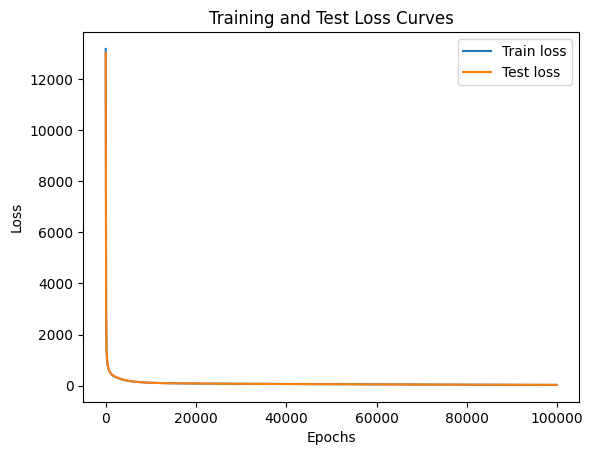

In [18]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

Predictions

In [29]:
from scipy.stats import norm
from scipy.optimize import curve_fit

Text(0.5, 1.0, 'Predicted Energy Distribution')

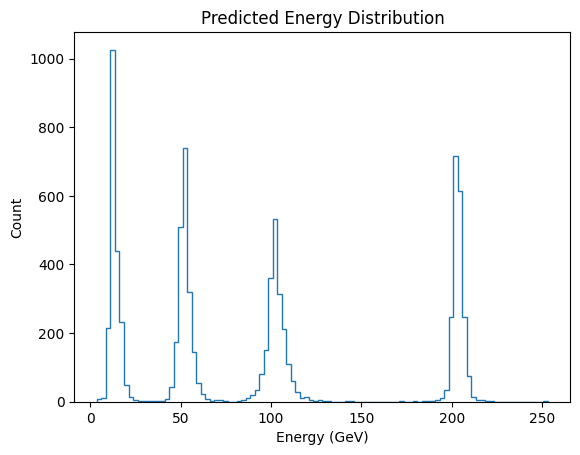

In [30]:
#Set the model in evaluation mode
model_1.eval()

#Setup the inference mode context manager
with torch.inference_mode():
  y_preds = model_1(x_test)

plt.hist(y_preds[:,0].numpy(),100,histtype='step')
plt.xlabel('Energy (GeV)')
plt.ylabel('Count')
plt.title('Predicted Energy Distribution')

In [31]:
#Set the model in evaluation mode
model_1.eval()

#Setup the inference mode context manager
with torch.inference_mode():
  y_preds_200GeV = model_1(features_200GeV)
  y_preds_100GeV = model_1(features_100GeV)
  y_preds_50GeV = model_1(features_50GeV)
  y_preds_10GeV = model_1(features_10GeV)

In [32]:
peak_preds = norm.fit(y_preds_10GeV)[0], norm.fit(y_preds_50GeV)[0], norm.fit(y_preds_100GeV)[0], norm.fit(y_preds_200GeV)[0]
true_peaks = [10,50,100,200]
peak_preds

(13.514928, 52.314564, 102.69796, 203.00795)

Text(0.5, 1.0, 'Linearity')

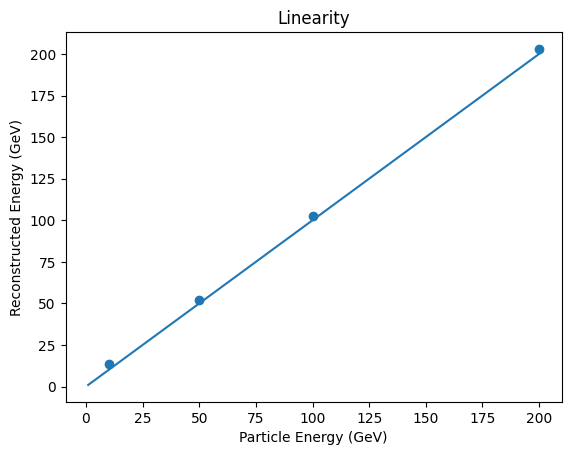

In [33]:
plt.scatter(true_peaks,peak_preds)
plt.xlabel('Particle Energy (GeV)')
plt.ylabel('Reconstructed Energy (GeV)')
plt.plot(np.arange(1,201),np.arange(1,201))
plt.title('Linearity')

In [34]:
#Get energy resolution from distribution of predictions
def res(preds,energy):
    return norm.fit(preds)[1]/energy

energy_list = [200,100,50,10]
resolutions = res(y_preds_200GeV,200), res(y_preds_100GeV,100), res(y_preds_50GeV,50), res(y_preds_10GeV,10)

In [35]:
#Curve fit for energy resolution as a function of energy
def f(E,a):
    return a/np.sqrt(E)

popt, pcov = curve_fit(f, energy_list, resolutions)

In [36]:
popt, pcov

(array([0.75193083]), array([[0.00623642]]))

Text(0.5, 1.0, 'Energy Resolution')

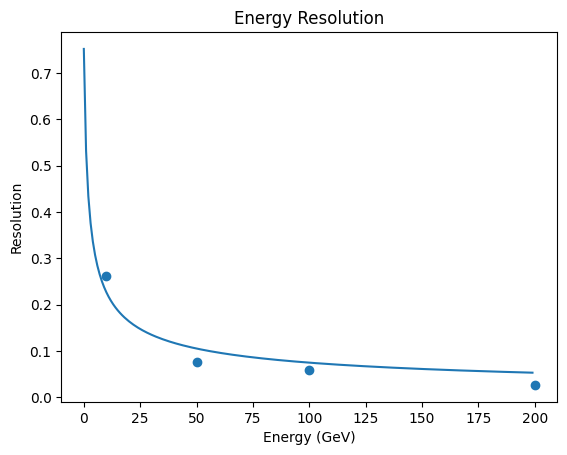

In [37]:
plt.plot(range(200),f(range(1,201),popt[0]))
plt.scatter(energy_list,resolutions)
plt.xlabel('Energy (GeV)')
plt.ylabel('Resolution')
plt.title('Energy Resolution')

In [38]:
torch.save(obj=model_1.state_dict(), f="/home/dmisra/eic/model_1")

In [72]:
model_1.load_state_dict(torch.load('/home/dmisra/eic/model_1')())

<All keys matched successfully>